In [1]:
from datetime import datetime, timedelta
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline
%config IPCompleter.greedy = True
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt
import cbpro
import os
from pathlib import Path
import seaborn as sns
import xgboost as xgb

os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"
os.environ["TF_GPU_THREAD_MODE"] = "gpu_private"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
import tensorflow_probability as tfp

tf.distribute.OneDeviceStrategy(device="/gpu:0")
policy = tf.keras.mixed_precision.Policy("mixed_float16")
tf.keras.mixed_precision.experimental.set_policy(policy)

public_client = cbpro.PublicClient()

class MinerMeta(type):
    # def __init__(self):
    #     result = getattr(self, "df", None)
    #     if result is None:
    #         self.df = self.compile_historic(read_csv=True)

    def compile_historic(self, num_days=100, write_csv=False, read_csv=False):
        file = Path.cwd() / f"{self.coin}_histdata.csv"
        if read_csv is True:
            df = pd.read_csv(file, index_col="time", infer_datetime_format=True)
            return df
        else:
            finish = datetime.now()
            start = finish - timedelta(num_days)
            delta = timedelta(hours=300)
            df = pd.DataFrame()

            while finish > start:
                historic = public_client.get_product_historic_rates(
                    f"{self.coin}-USD",
                    granularity=3600,
                    start=start,
                    end=start + delta,
                )
                start += delta
                df = df.append(historic, ignore_index=True, verify_integrity=True)
            df.columns = ["time", "low", "high", "open", "close", "volume"]

            # timestamp_s = date_time.map(pd.Timestamp.timestamp)
            # day = 24 * 60 * 60
            # year = (365.2425) * day
            # df["Day sin"] = np.sin(timestamp_s * (2 * np.pi / day))
            # df["Day cos"] = np.cos(timestamp_s * (2 * np.pi / day))
            # df["Year sin"] = np.sin(timestamp_s * (2 * np.pi / year))
            # df["Year cos"] = np.cos(timestamp_s * (2 * np.pi / year))

            df["time"] = pd.to_datetime(df["time"], unit="s")
            df.set_index("time", inplace=True, verify_integrity=False)
            df.sort_index(ascending=False)

            if write_csv is True:
                df.to_csv(file, index=True)

            return df

    def get_day_stats(self):
        result = getattr(self, "day_stats", None)
        if result is None:
            ticker = public_client.get_product_24hr_stats(f"{self.coin}-USD")
            df = pd.DataFrame.from_dict(ticker, orient="index")
            self.day_stats = df
        return df

    def year_day_fft(self, col):
        df = self.compile_historic()
        today = datetime.today()
        ylim = int(df[col].max())
        plt.figure(figsize=(15, 10))

        fft = tf.signal.rfft(df[col])
        f_per_dataset = np.arange(0, len(fft))

        n_samples_h = 1
        hours_per_year = 24 * 365.2524
        hours_per_week = 24 * 7
        years_per_dataset = n_samples_h / (hours_per_year)
        hours_per_dataset = n_samples_h / (hours_per_week)

        f_per_year = f_per_dataset / years_per_dataset
        f_per_week = f_per_dataset / hours_per_dataset
        plt.step(f_per_week, np.abs(fft))
        plt.xscale("log")
        # plt.ylim(1000, ylim)
        # plt.xlim([0.1, max(plt.xlim())])
        plt.xticks([1, 7], labels=["1/Week", "1/day"])
        plt.xlabel("Frequency (log scale)")

        return plt.show()

    def ttsplit_norm(self, df, split_time=0.7, feature_plot=False):
        # train_df Test Split
        n = len(df)
        train_df = df[0 : int(n * 0.7)]
        val_df = df[int(n * 0.7) : int(n * 0.9)]
        test_df = df[int(n * 0.9) :]
        # Normalize the Data
        train_df_mean = train_df.mean()
        train_df_std = train_df.std()

        train_df = (train_df - train_df_mean) / train_df_std
        val_df = (val_df - train_df_mean) / train_df_std
        test_df = (test_df - train_df_mean) / train_df_std

        # Create Feature Plot if wanted
        if feature_plot is True:
            df_std = (df - train_df_mean) / train_df_std
            df_std = df_std.melt(var_name="Column", value_name="Normalized")
            plt.figure(figsize=(12, 6))
            ax = sns.violinplot(x="Column", y="Normalized", data=df_std)
            ax.set_xticklabels(df.keys(), rotation=90)
            ax.set_title("train_dfing Data Feature Dist with whole DF Mean")

            return train_df, val_df, test_df

        return train_df, val_df, test_df

    def __call__(self, *args, **kwargs):

        cls = type.__call__(self, *args)

        # setattr(cls, "compile_historic", self.compile_historic)
        # setattr(cls, "year_day_fft", self.year_day_fft)
        # setattr(cls, "ttsplit_norm", self.ttsplit_norm)
        # setattr(cls, "get_day_stats", self.get_day_stats)
        # setattr(cls, "day_stats", self.get_day_stats())

        # for key, value in historic.items():
        #     setattr(cls, "hist_" + key, value)
        # for key, value in ticker.items():
        #     setattr(cls, "tick_" + key, value)

        return cls


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1660, compute capability 7.5


In [2]:
class eth(metaclass=MinerMeta):
    coin = "eth"


df = eth.compile_historic(read_csv=True)
df.head()


,low,high,open,close,volume
time,,,,,
10/6/2021 18:00,3579.12,3610.65,3579.12,3586.88,8193.984944
10/6/2021 17:00,3562.86,3600.00,3598.94,3578.95,9145.609129
10/6/2021 16:00,3555.46,3622.86,3613.79,3599.15,15561.658640
10/6/2021 15:00,3588.48,3632.44,3599.48,3614.20,23533.817950
10/6/2021 14:00,3547.70,3600.50,3580.00,3599.49,11426.364240


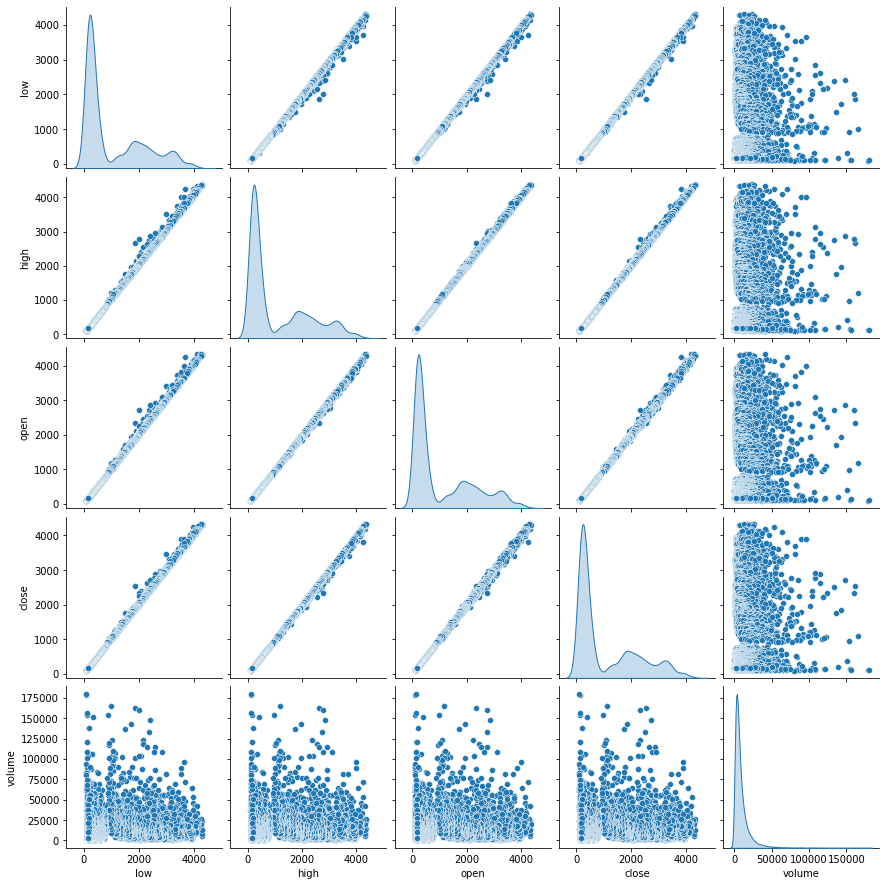

In [3]:
cols = list(df.columns)

sns.pairplot(df[cols], diag_kind="kde")


In [4]:
def tt_split(df, train_percent=0.6, val_percent=0.2):
    m = len(df.index)
    train_end = int(train_percent * m)
    val_end = int(val_percent * m) + train_end
    train = df.iloc[:train_end]
    val = df.iloc[train_end:val_end]
    test = df.iloc[val_end:]
    train = (train - train.mean()) / train.std()
    return train, val, test


train, val, test = tt_split(df)
label = train.pop("close")
test_label = test.pop("close")
val_label = val.pop("close")

dtrain = xgb.DMatrix(train, label=label)
dval = xgb.DMatrix(val, label=val_label)


In [5]:
param = {"max_depth": 50, "eta": 1, "objective": "reg:squarederror"}
evallist = [(dval, "eval"), (dtrain, "train")]

num_round = 2
bst = xgb.train(param, dtrain, num_round, evallist)


[0]	eval-rmse:203.23283	train-rmse:0.03527
[1]	eval-rmse:203.07463	train-rmse:0.00814


In [6]:
val_pred = xgb.DMatrix(val[:10])
preds = bst.predict(val_pred)

print(val[:10])

print(preds)


                    low    high    open        volume
time                                                 
7/25/2020 14:00  283.00  284.72  284.43   4207.556360
7/25/2020 13:00  282.20  288.26  285.32  15048.019390
7/25/2020 12:00  282.78  285.57  282.93   5317.398226
7/25/2020 11:00  282.61  284.12  282.92   1828.303316
7/25/2020 10:00  281.82  283.85  283.43   3882.915475
7/25/2020 9:00   283.03  285.15  284.10   2951.166804
7/25/2020 8:00   282.96  284.93  283.34   3372.223166
7/25/2020 7:00   282.96  284.66  284.66   3306.437354
7/25/2020 6:00   284.10  286.24  284.64   3820.442247
7/25/2020 5:00   282.94  285.42  283.70   8897.463734
[2.3760266 2.3760266 2.3760266 2.3760266 2.3760266 2.3760266 2.3760266
 2.3760266 2.3760266 2.3760266]


In [7]:
from sklearn.model_selection import cross_val_score, RepeatedKFold

model = xgb.XGBRegressor()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(
    model, train, label, scoring="neg_mean_absolute_error", cv=cv, n_jobs=-1
)
scores = np.abs(scores)
print("Mean MAE: %.3f (%.3f)" % (scores.mean(), scores.std()))


Mean MAE: 0.008 (0.000)


In [8]:
model.fit(train, label)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [9]:
print(test[:1])
print(test_label[:1])
yhat = model.predict(test[:1])
print()
print('Predicted: %.3f' % yhat)
print(yhat)

                   low    high    open       volume
time                                               
3/1/2020 14:00  220.08  223.22  222.34  2744.761373
time
3/1/2020 14:00    220.3
Name: close, dtype: float64

Predicted: 2.442
[2.441711]
